In [76]:
import sys

sys.path.append(sys.path[0].replace('StewartTest','StewartLibrary'))

import main_Stuart as ms

import main_functions_Stewart_platform as mf

import numpy as np

import pandas as pd

import torch

from torch import nn

import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

In [77]:
# Класс для оставляния датасета внутри класса
# решить вопрос с инициализацией, тк нельзя в инициализации возвращать что либо.
class Model_Stuart_from_model():

    def __init__(self, model, n):
        # Создание модели стюарта
        self.model = model
        # Сохранение результатов
        self.results = np.array([])
        # Сохранение промежуточных результатов
        self.intermediate_result = np.array([])
        # Создание цикла для формирования датасета
        size = n
        while n != 0:
            # Генерация перемещений
            coordinates = (np.random.rand(
                3)*self.model.max_len)-self.model.max_len/2
            # Генерация углов поворота
            angle = 90*np.random.rand(3)
            # Сохранение координат верхней платформы
            self.model.change_of_position_upper_platform(alfa=angle[0], betta=angle[1], gamma=angle[2],

                                                         x=coordinates[0], y=coordinates[1], z=coordinates[2])
            # Расчитываем углы
            self.model.angle()
            # Расчитываем длинны
            self.model.len_leg()

            if sum(self.model.test_lens) == 6 and sum(sum(self.model.test_angle)) == 12:

                self.intermediate_result = np.concatenate(
                    (np.concatenate((angle, coordinates)), self.model.len))

                self.intermediate_result = self.intermediate_result.reshape(
                    1, -1)

                self.results = np.append(
                    self.results, self.intermediate_result)

                n -= 1

            else:
                print('Длинны ног', self.model.len, self.model.test_lens, 'Углы наклона ног',
                      self.model.angle_lens, self.model.test_angle, '--------------------', sep='\n')
                self.model.coordinates_upper_platform = mf.calculation_new_coordinates(
                    self.model._Stuart__inv_matrix, self.model.coordinates_upper_platform).reshape(-1, 3)

        self.results = self.results.reshape(size, -1)


In [78]:
# Класс для выведения датасета как переменной
class Model_Stuart():

    def __init__(self, model, n):
        # Создание модели стюарта
        self.model = model
        # Сохранение результатов
        self.results = np.array([])
        # Сохранение промежуточных результатов
        self.intermediate_result = np.array([])
        # Создание цикла для формирования датасета

        self.n = n

        self.x = np.array([])

        self.y = np.array([])

    def dataset(self,pandas_df =True , prints=False):
        while self.n != 0:
            # Генерация перемещений
            coordinates = 0.1*((np.random.rand(3)*self.model.max_len)-self.model.max_len/2)
            # Генерация углов поворота
            angle = 90*np.random.rand(3) - 45
            # Сохранение координат верхней платформы
            self.model.change_of_position_upper_platform(alfa=angle[0], betta=angle[1], gamma=angle[2],

                                                         x=coordinates[0], y=coordinates[1], z=coordinates[2])
            # Расчитываем углы
            self.model.angle()
            # Расчитываем длинны
            self.model.len_leg()

            if sum(self.model.test_lens) == 6 and sum(sum(self.model.test_angle)) == 12:

                self.intermediate_result = np.append((np.concatenate((np.concatenate(
                    (angle, coordinates)), self.model.len))), self.model.angle_lens.reshape(1, -1))

                self.intermediate_result = self.intermediate_result.reshape(
                    1, -1)

                self.results = np.append(
                    self.results, self.intermediate_result)

                self.n -= 1

            else:
                if prints == True:
                    print('Длинны ног', self.model.len, self.model.test_lens, 'Углы наклона ног',
                          self.model.angle_lens, self.model.test_angle, '--------------------', sep='\n')
                self.model.coordinates_upper_platform = mf.calculation_new_coordinates(
                    self.model._Stuart__inv_matrix, self.model.coordinates_upper_platform).reshape(-1, 3)

# 1 вектор размерностью 24
        self.results = self.results.reshape(-1, 24)

        self.x = self.results[:,:6]

        self.y = self.results[:,6:]

        columns_my = ['Угол поворота Х', 'Угол поворта Y', 'Угол поворота Z',
                      'Перемещение по Х', 'Перемещение по Y', 'Перемещение по Z',
                      'Длинна 1 ноги', 'Длинна 2 ноги', 'Длинна 3 ноги', 'Длинна 4 ноги', 'Длинна 5 ноги', 'Длинна 6 ноги',
                      'Угол поворота 1 ноги у нижней платформы', 'Угол поворота 1 ноги у верхней платформы', 'Угол поворота 2 ноги у нижней платформы', 'Угол поворота 2 ноги у верхней платформы', 'Угол поворота 3 ноги у нижней платформы', 'Угол поворота 3 ноги у верхней платформы',
                      'Угол поворота 4 ноги у нижней платформы', 'Угол поворота 4 ноги у верхней платформы', 'Угол поворота 5 ноги у нижней платформы', 'Угол поворота 5 ноги у верхней платформы', 'Угол поворота 6 ноги у нижней платформы', 'Угол поворота 6 ноги у верхней платформы']
        
        if pandas_df:
            return pd.DataFrame(self.results, columns=columns_my)
        else:
            return self.x,self.y

    def models(self,epoh,iter,plots = True):
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)
        self.network = nn.Sequential(
            nn.Linear(6,36),
            nn.ReLU(),
            nn.Linear(36, 144),
            nn.ReLU(),
            nn.Linear(144, 18),
            nn.ReLU(),
        )
        self.optimizer = torch.optim.Adam(network.parameters())
        self.losses = []
        for i in range(epoh):
            for j in tqdm(range(iter)):
                y_pred = self.network(self.x)
                loss = F.mse_loss(y_pred, self.y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.losses.append(loss.item())
        if plots:
            plt.plot(range(epoh*iter),self.losses)
#Ввод данных осуществляется только numpy
    def model_predict(self,data):
        return self.network(torch.Tensor(x))

In [79]:
import numpy as np
import main_Stuart as ms
import sys

sys.path.append(sys.path[0].replace('StewartTest', 'StewartLibrary/'))


model = ms.Stuart(coordinates_global=[0, 0, 0], min_len=3000,
                  max_len=7000, angles=45)
model.coordinate_lower_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=2000, R_lower=4000)
model.coordinate_upper_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=0, R_upper=3000)


Вы задали
Координаты глобальной системы:[0, 0, 0]
Минимальная и максимальная длинна ноги:(3000, 7000)
Минимальный и максимальный наклон ног:(45, 135)


In [81]:
e = Model_Stuart(model,10000)

In [82]:
x,y = e.dataset(pandas_df=False)

In [83]:
x = torch.Tensor(x)
y = torch.Tensor(y)

In [86]:
#Задаем 3 слоя 1)линейный с логарифмической функцией активации 
x = torch.Tensor(x)
y = torch.Tensor(y)
network = nn.Sequential(
    nn.Linear(6,50),
    nn.ReLU(),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Linear(100,40),
    nn.ReLU(),
    nn.Linear(40,20),
    nn.ReLU(),
    nn.Linear(20,18),
    nn.ReLU()
)
optimizer = torch.optim.Adam(network.parameters())
epoh = 10
iteration = 7500
losses = []
for i in range(epoh):
    for j in tqdm(range(iteration)):
        y_pred = network(x)
        loss = F.mse_loss(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
plt.plot(range(epoh*iteration),losses)


 16%|█▋        | 1222/7500 [00:28<02:24, 43.39it/s]


KeyboardInterrupt: 

In [85]:
print('Выход из модели:',network(x[0]),'\n','Истинное значение велечин: ',y[0],'\n''Значение ошибки:',loss)

Выход из модели: tensor([4497.7852,    0.0000, 5887.9014, 6573.3350, 6311.6621, 5319.4102,
          48.8502,    0.0000,    0.0000,   76.7295,   86.5054,   56.4383,
          82.9962,   50.0418,   57.6640,   65.6006,    0.0000,   73.3465],
       grad_fn=<ReluBackward0>) 
 Истинное значение велечин:  tensor([3386.0247, 5333.4033, 6855.7427, 6969.7344, 5621.1357, 3611.2532,
          51.7886,   86.5193,   47.9842,   85.1105,   52.4388,   73.6907,
          63.3848,   60.5491,   72.1354,   56.2951,   64.4924,   70.9242]) 
Значение ошибки: tensor(1353558., grad_fn=<MseLossBackward0>)


In [82]:
class test_dataset():

    def __init__(self, model, n):
        # Создание модели стюарта
        self.model = model
        # Сохранение результатов
        self.results = np.array([])
        # Сохранение промежуточных результатов
        self.intermediate_result = np.array([])
        # Создание цикла для формирования датасета

        self.n = n

        self.x = np.array([])

        self.y = np.array([])

        self.size = n

        self.platform = np.array([])

    def dataset(self,pandas_df =True , prints=False):
        while self.n != 0:
            # Генерация перемещений
            self.coordinates = 0.1*((np.random.rand(3)*self.model.max_len)-self.model.max_len/2)
            # Генерация углов поворота
            self.angle = 90*np.random.rand(3) - 45
            # Сохранение координат верхней платформы
            self.model.change_of_position_upper_platform(alfa=self.angle[0], betta=self.angle[1], gamma=self.angle[2],

                                                         x=self.coordinates[0], y=self.coordinates[1], z=self.coordinates[2])
            # Расчитываем углы
            self.model.angle()
            # Расчитываем длинны
            self.model.len_leg()

            if sum(self.model.test_lens) == 6 and sum(sum(self.model.test_angle)) == 12:

                self.platform = np.append(self.platform,np.concatenate([self.model.coordinates_upper_platform.reshape(1,-1),self.angle.reshape(1,-1),self.coordinates.reshape(1,-1),self.model.coordinates_lower_platform.reshape(1,-1)],axis=1))

                self.intermediate_result = np.append((np.concatenate((np.concatenate(
                    (self.angle, self.coordinates)), self.model.len))), self.model.angle_lens.reshape(1, -1))

                self.intermediate_result = self.intermediate_result.reshape(
                    1, -1)

                self.results = np.append(
                    self.results, self.intermediate_result)

                self.n -= 1

            else:
                if prints == True:
                    print('Длинны ног', self.model.len, self.model.test_lens, 'Углы наклона ног',
                          self.model.angle_lens, self.model.test_angle, '--------------------', sep='\n')
                self.model.coordinates_upper_platform = mf.calculation_new_coordinates(
                    self.model._Stuart__inv_matrix, self.model.coordinates_upper_platform).reshape(-1, 3)

        #self.results = self.results.reshape(size,-1)

        self.results = self.results.reshape(self.size, -1)

        self.x = self.results[:,:6]

        self.y = self.results[:,6:]

        self.platform = self.platform.reshape(-1,48)

        columns_my = ['Угол поворота Х', 'Угол поворта Y', 'Угол поворота Z',
                      'Перемещение по Х', 'Перемещение по Y', 'Перемещение по Z',
                      'Длинна 1 ноги', 'Длинна 2 ноги', 'Длинна 3 ноги', 'Длинна 4 ноги', 'Длинна 5 ноги', 'Длинна 6 ноги',
                      'Угол поворота 1 ноги у нижней платформы', 'Угол поворота 1 ноги у верхней платформы', 'Угол поворота 2 ноги у нижней платформы', 'Угол поворота 2 ноги у верхней платформы', 'Угол поворота 3 ноги у нижней платформы', 'Угол поворота 3 ноги у верхней платформы',
                      'Угол поворота 4 ноги у нижней платформы', 'Угол поворота 4 ноги у верхней платформы', 'Угол поворота 5 ноги у нижней платформы', 'Угол поворота 5 ноги у верхней платформы', 'Угол поворота 6 ноги у нижней платформы', 'Угол поворота 6 ноги у верхней платформы']
        nin = ''
        verh = ''
        verh = [[f'x_{i} координата верхней платформы',f'y_{i} координата верхней платформы',f'z_{i} координата верхней платформы'] if i!=7 else [f'x координата центра верхней платформы',f'y координата центра верхней платформы',f'z координата центра верхней платформы'] for i in range(1,8)]
        verh = [j for i in verh for j in i]
        niz = [[f'x_{i} координата нижней платформы',f'y_{i} координата нижней платформы',f'z_{i} координата нижней платформы'] if i!=7 else [f'x координата центра нижней платформы',f'y координата центра нижней платформы',f'z координата центра нижней платформы'] for i in range(1,8)]
        niz = [j for i in niz for j in i]
        anglen = ['Угол поворота Х', 'Угол поворта Y', 'Угол поворота Z','Перемещение по Х', 'Перемещение по Y', 'Перемещение по Z',]
        columns_up_down = [j for i in [verh,anglen,niz] for j in i]
        if pandas_df:
            return pd.DataFrame(self.results, columns=columns_my),pd.DataFrame(self.platform,columns=columns_up_down)
        else:
            return self.x,self.y,self.platform


In [83]:
import numpy as np
import main_Stuart as ms
import sys

sys.path.append(sys.path[0].replace('StewartTest', 'StewartLibrary/'))


model = ms.Stuart(coordinates_global=[0, 0, 0], min_len=3000,
                  max_len=7000, angles=45)
model.coordinate_lower_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=2000, R_lower=4000)
model.coordinate_upper_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=0, R_upper=3000)

Вы задали
Координаты глобальной системы:[0, 0, 0]
Минимальная и максимальная длинна ноги:(3000, 7000)
Минимальный и максимальный наклон ног:(45, 135)


In [87]:
e = test_dataset(model,100000)
df1,df2 = e.dataset(pandas_df=True)

KeyboardInterrupt: 

In [114]:
nin = ''
verh = ''
verh = [[f'x_{i} координата верхней платформы',f'y_{i} координата верхней платформы',f'z_{i} координата верхней платформы'] if i!=7 else [f'x координата центра верхней платформы',f'y координата центра верхней платформы',f'z координата центра верхней платформы'] for i in range(1,8)]
verh = [j for i in verh for j in i]
niz = [[f'x_{i} координата нижней платформы',f'y_{i} координата нижней платформы',f'z_{i} координата нижней платформы'] if i!=7 else [f'x координата центра нижней платформы',f'y координата центра нижней платформы',f'z координата центра нижней платформы'] for i in range(1,8)]
niz = [j for i in niz for j in i]
anglen = ['Угол поворота Х', 'Угол поворта Y', 'Угол поворота Z','Перемещение по Х', 'Перемещение по Y', 'Перемещение по Z',]
columns_up_down = [j for i in [verh,anglen,niz] for j in i]
xy = e.platform.reshape(-1,48)
x= xy[:,:27]
y = xy[:,27:]

100%|██████████| 450/450 [00:00<00:00, 688.71it/s]


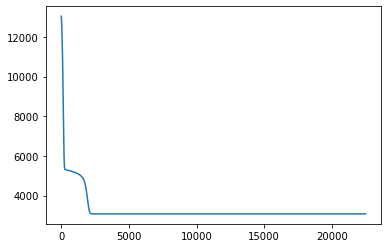

In [98]:
x = torch.Tensor(x)
y = torch.Tensor(y)
network = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,2),
    nn.ReLU(),
    nn.Linear(2,1)
)
optimizer = torch.optim.Adam(network.parameters())
epoh = 50
iteration = 450
losses = []
for i in range(epoh):
    for j in tqdm(range(iteration)):
        y_pred = network(x)
        loss = F.mse_loss(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
plt.plot(range(epoh*iteration),losses)

In [99]:
print(network(x[999]),y[999])

tensor([102.0459], grad_fn=<AddBackward0>) tensor(198.)


In [97]:
import numpy as np
import pandas as pd
x = np.linspace(1,100,1000)
z = np.linspace(5,98,1000)
y = (x+z)
x = np.array([x,z]).transpose()
y = y.transpose()

In [47]:
y.size

1000

In [48]:
x = np.array([x,z]).transpose()

In [19]:
x.shape

(1000, 2)

In [113]:
y[10].shape

torch.Size([22])

In [120]:
network(x[1])

tensor([4004.1255,    0.0000, 2002.1410, 2001.9508, 3467.6997, 2002.1193,
           0.0000, 3467.6719, 2002.0238,    0.0000,    0.0000, 2002.0658,
           0.0000,    0.0000,    0.0000, 2001.9799,    0.0000, 2002.4513,
           0.0000,    0.0000, 2002.1205], grad_fn=<ReluBackward0>)

In [121]:
y[1]

tensor([ 4.0000e+03,  0.0000e+00,  2.0000e+03,  2.0000e+03,  3.4641e+03,
         2.0000e+03, -2.0000e+03,  3.4641e+03,  2.0000e+03, -4.0000e+03,
         4.8986e-13,  2.0000e+03, -2.0000e+03, -3.4641e+03,  2.0000e+03,
         2.0000e+03, -3.4641e+03,  2.0000e+03,  0.0000e+00,  0.0000e+00,
         2.0000e+03])

In [100]:
xy[:,:26].shape

(40645, 26)

In [72]:
e.model.coordinates_upper_platform.reshape(1,-1).shape

(1, 21)

In [74]:
e.coordinates.reshape(1,-1).shape

(1, 3)

In [49]:
re = np.array([1,2,3])
qe = np.array([2,3,3])
we = np.array([3,2,3])
ee = np.array([4,2,3])

In [50]:
np.concatenate([re,qe,we,ee])

array([1, 2, 3, 2, 3, 3, 3, 2, 3, 4, 2, 3])

In [27]:
2*3*7

42

In [28]:
np.concatenate([np.array([12,3,4]),np.array([1,5,6])])

array([12,  3,  4,  1,  5,  6])

In [29]:
import numpy as np
import main_Stuart as ms
import sys

sys.path.append(sys.path[0].replace('StewartTest', 'StewartLibrary/'))


model = ms.Stuart(coordinates_global=[0, 0, 0], min_len=3000,
                  max_len=7000, angles=45)
model.coordinate_lower_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=2000, R_lower=4000)
model.coordinate_upper_platform(alfa=0, betta=0, gamma=0,
                                x=0, y=0, z=0, R_upper=3000)

Вы задали
Координаты глобальной системы:[0, 0, 0]
Минимальная и максимальная длинна ноги:(3000, 7000)
Минимальный и максимальный наклон ног:(45, 135)


In [30]:
e = test_dataset(model,10)
e.dataset()

(   Угол поворота Х  Угол поворта Y  Угол поворота Z  Перемещение по Х  \
 0         2.618391       19.001139       -37.951320         34.671086   
 1        -5.305597        9.975395       -23.117564        -76.161320   
 2       -30.748196        0.005603       -24.840122        -39.411429   
 3        40.732715       22.773573        33.764881       -265.758964   
 4       -35.871234       14.939505       -21.739531         80.000043   
 5        13.133044      -13.613706        -2.275788        219.001059   
 6        22.331453        2.427090        37.329529          1.753285   
 7         4.938584        7.525661        39.816297         96.257744   
 8       -18.226936       -7.570371       -30.423570         60.178144   
 9        17.600559       11.047666        26.577363       -168.313988   
 
    Перемещение по Y  Перемещение по Z  Длинна 1 ноги  Длинна 2 ноги  \
 0        291.025175       -172.786708    3363.986858    4384.563224   
 1        -70.996028       -258.822049  

In [31]:
np.linalg.det(model.coordinates_lower_platform[-3:])

27712812921.101994

In [32]:
#Создание колонок для верхних и нижних координат платформы
nin = ''
verh = ''
verh = [[f'x_{i} координата верхней платформы',f'y_{i} координата верхней платформы',f'z_{i} координата верхней платформы'] if i!=7 else [f'x координата центра верхней платформы',f'y координата центра верхней платформы',f'z координата центра верхней платформы'] for i in range(1,8)]
verh = [j for i in verh for j in i]
niz = [[f'x_{i} координата нижней платформы',f'y_{i} координата нижней платформы',f'z_{i} координата нижней платформы'] if i!=7 else [f'x координата центра нижней платформы',f'y координата центра нижней платформы',f'z координата центра нижней платформы'] for i in range(1,8)]
niz = [j for i in niz for j in i]
columns_up_down = [j for i in [verh,niz] for j in i]

In [33]:
columns_up_down

['x_1 координата верхней платформы',
 'y_1 координата верхней платформы',
 'z_1 координата верхней платформы',
 'x_2 координата верхней платформы',
 'y_2 координата верхней платформы',
 'z_2 координата верхней платформы',
 'x_3 координата верхней платформы',
 'y_3 координата верхней платформы',
 'z_3 координата верхней платформы',
 'x_4 координата верхней платформы',
 'y_4 координата верхней платформы',
 'z_4 координата верхней платформы',
 'x_5 координата верхней платформы',
 'y_5 координата верхней платформы',
 'z_5 координата верхней платформы',
 'x_6 координата верхней платформы',
 'y_6 координата верхней платформы',
 'z_6 координата верхней платформы',
 'x координата центра верхней платформы',
 'y координата центра верхней платформы',
 'z координата центра верхней платформы',
 'x_1 координата нижней платформы',
 'y_1 координата нижней платформы',
 'z_1 координата нижней платформы',
 'x_2 координата нижней платформы',
 'y_2 координата нижней платформы',
 'z_2 координата нижней плат

In [34]:
def columns(all = True,coordination_lower_platform = [i for i in range(1,8)],coordination_upper_platformlens = [i for i in range(1,8)],angels_lower_platform=[i for i in range(1,7)],angels_upper_platform =[i for i in range(1,7)],lens = [i for i in range(1,7)],angels = True,mooving=True,min_max_lens=False,min_max_angels=False):


#Создание названия колонок для координат верхней и нижней платформы
    upper_platform = [[f'x_{i} координата верхней платформы',f'y_{i} координата верхней платформы',f'z_{i} координата верхней платформы'] if i!=7 else [f'x координата центра верхней платформы',f'y координата центра верхней платформы',f'z координата центра верхней платформы'] for i in e['coordination_upper_platform']]
    upper_platform = [j for i in upper_platform for j in i]
    lower_platform = [[f'x_{i} координата нижней платформы',f'y_{i} координата нижней платформы',f'z_{i} координата нижней платформы'] if i!=7 else [f'x координата центра нижней платформы',f'y координата центра нижней платформы',f'z координата центра нижней платформы'] for i in range(1,8)]
    lower_platform = [j for i in lower_platform for j in i]


#Создание колонок для углов поворотов и перемещений верхней платформы 
    angels = ['Угол поворота Х', 'Угол поворта Y', 'Угол поворота Z']
    mooving = ['Перемещение по Х', 'Перемещение по Y', 'Перемещение по Z']

#Создание колонок для длинн ног и углов наклона ног к платформам
    lens = [f'Длинна {i} ноги' for i in lens]
    angels_lower_platform = [f'Координаты {i} точки нижней платформы' for i in angels_lower_platform]
    angels_upper_platform = [f'Координаты {i} точки верхней платформы' for i in angels_upper_platform]

In [35]:
class Special_fo_dataset():
    def upper_platform(data,columns = [i for i in range(1,8)]):
        columns = [i if i!='C' else 7 for i in range(1,8)]
        upper_platform = [[f'x_{i} координата верхней платформы',f'y_{i} координата верхней платформы',f'z_{i} координата верхней платформы'] if i!=7 else [f'x координата центра верхней платформы',f'y координата центра верхней платформы',f'z координата центра верхней платформы'] for i in columns]
        upper_platform = [j for i in upper_platform for j in i]
        columns = [j for i in columns for j in range(3*i,3*i+3)]
        return pd.DataFrame(data[:,columns])

In [36]:
Special_fo_dataset.upper_platform(np.array([[1,2,3,4,5,6],[2,3,4,5,6,7]])[:,1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
np.array([[1,2,3,4,5,6],[2,3,4,5,6,7]])[:2]

array([[1, 2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6, 7]])

In [ ]:
np.array([[1,2,3],[1,2,5],[9,8,4]])[er]

array([[1, 2, 5],
       [9, 8, 4]])

In [ ]:
er = [1,2]

In [ ]:
e = [1,2]

In [1]:
from turtle import *
left(90)
pensize(10)
penup()
forward(100)
pendown()
pencolor("red")
begin_fill()
circle(70,230)
pensize(10)
pencolor("red")

pencolor("red",)
forward(140)
seth(40)
forward(135)
pencolor("red")
right(5)
circle(70,210)
pencolor("black")

seth(30)
fillcolor("red")
end_fill()
seth(-90)
pencolor("red")
pensize(3)
forward(50)
pencolor("black")


hideturtle()
done()


In [ ]:
import pandas as pd
import numpy as np

def funk1(x):
    return 